<a href="https://colab.research.google.com/github/w114050009-maker/YoLo/blob/main/YOLOv3_Kaggle_CarObjDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Part 1: YOLOv3**

## **Introduction**

YOLO is a series of real-time object detection method.

YOLOv3 ([paper](https://arxiv.org/pdf/1804.02767.pdf)):
1. Anchor Based
2. Darknet-53
3. Feature Pyramid Networks (FPN)



### **Darknet-53**

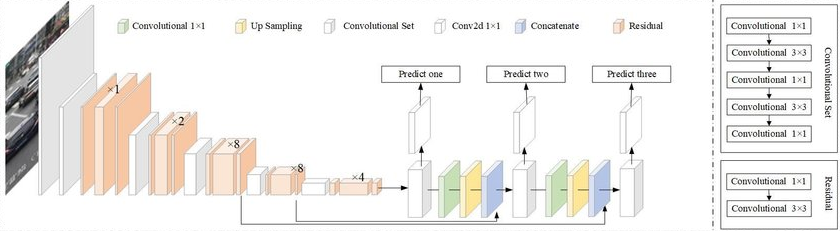

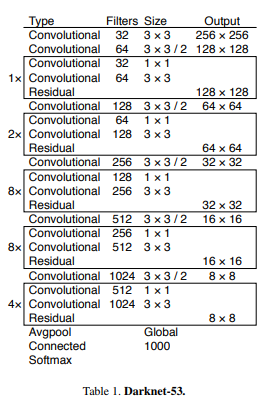

# **Environment Checking**

Please make sure your runtime type is ***GPU*** or ***TPU***

Check GPU by using the following command:

In [ ]:
!nvidia-smi

# **Setup YOLOv3**

This section is used to setup YOLOv3 and its environment.

## **Download Project**

We use [ultralytics/yolov3](https://github.com/ultralytics/yolov3), which is pytorch version of YOLOv3 and is made by the author of YOLOv5.

Use `git clone` command for download project from github.

In [ ]:
!git clone https://github.com/ws6125/yolov3_pytorch.git

## **Install required packages**

In [ ]:
%cd yolov3_pytorch
%pip install -r requirements.txt

# **Download Dataset**

## **Dataset: Car Object Detection from Kaggle**

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import yaml

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sshikamaru/car-object-detection")
DATASET_PATH = path + "/data/"
TRAINING_IMAGES_PATH = DATASET_PATH + "/training_images/"

#print(os.getcwd())
print("Path to dataset files:", DATASET_PATH)

In [ ]:
df = pd.read_csv(DATASET_PATH + "train_solution_bounding_boxes (1).csv")

df.shape, df[:5]

In [ ]:
target = df.iloc[0]
img = plt.imread(TRAINING_IMAGES_PATH + target["image"])

plt.imshow(img)

plt.plot([target["xmin"], target["xmax"], target["xmax"], target["xmin"], target["xmin"]],
         [target["ymin"], target["ymin"], target["ymax"], target["ymax"], target["ymin"]], c="red")

plt.show()

In [ ]:
height, width, channels = img.shape
height, width, channels

In [ ]:
def normalize(target, base):
    return target / base

df["class"] = 0 #only one class for car
df["width"] = normalize(df["xmax"] - df["xmin"], width)
df["height"] = normalize(df["ymax"] - df["ymin"], height)
df["x_center"] = normalize((df["xmax"] + df["xmin"])/2, width)
df["y_center"] = normalize((df["ymax"] + df["ymin"])/2, height)

df["image_name"] = df["image"]
df["image_path"] = TRAINING_IMAGES_PATH + df["image"]


yolov3_df = df[["class", "width", "height", "x_center", "y_center", "image_name", "image_path"]]
yolov3_df

In [ ]:
print("current path: " + os.getcwd())
!mkdir -p "../dataset/kaggle/working/data"
!mkdir -p "../dataset/kaggle/working/data/train"
!mkdir -p "../dataset/kaggle/working/data/train/images"
!mkdir -p "../dataset/kaggle/working/data/train/labels"
!mkdir -p "../dataset/kaggle/working/data/val"
!mkdir -p "../dataset/kaggle/working/data/val/images"
!mkdir -p "../dataset/kaggle/working/data/val/labels"

TRAIN_IMAGES_PATH = "../dataset/kaggle/working/data/train/images"
VAL_IMAGES_PATH = "../dataset/kaggle/working/data/val/images"
TRAIN_LABLES_PATH = "../dataset/kaggle/working/data/train/labels"
TRAIN_IMAGES_PATH = "../dataset/kaggle/working/data/train/images"
VAL_LABLES_PATH = "../dataset/kaggle/working/data/val/labels"
VAL_IMAGES_PATH = "../dataset/kaggle/working/data/val/images"

In [ ]:
train_data, val_data= train_test_split(yolov3_df, test_size=0.3, random_state=42)

def clear_folder(path):
    for entry in os.scandir(path):
        if entry.is_file():
            os.remove(entry.path)


def copy_data_to_folder(path, data):
    file_list = data.image_path.values
    for file_path in file_list:
        dest_path = os.path.join(path, os.path.basename(file_path))
        shutil.copy(file_path, dest_path)


def handle_train_data_and_val_data(path, data):
    clear_folder(path)
    copy_data_to_folder(path, data)

handle_train_data_and_val_data(TRAIN_IMAGES_PATH, train_data)
handle_train_data_and_val_data(VAL_IMAGES_PATH, val_data)

In [ ]:
def write_label_file(data, labels_path, images_path):
    for image_name in os.listdir(images_path):
        label_file_path = os.path.join(labels_path, image_name[:-4] + ".txt")
        with open(label_file_path, "w+") as file:
            columns = ["class", "x_center", "y_center", "width", "height"]
            rows = data[data["image_name"] == image_name][columns].values
            for row in rows:
                file.write(" ".join(row.astype(str)) + "\n")


write_label_file(train_data, TRAIN_LABLES_PATH, TRAIN_IMAGES_PATH)
write_label_file(val_data, VAL_LABLES_PATH, VAL_IMAGES_PATH)

In [ ]:
car_pred_yaml_dict = dict(path = "../dataset/kaggle/working/data",
                 train = "../dataset/kaggle/working/data/train",
                 val = "../dataset/kaggle/working/data/val",
                 nc = 1,
                 names = ["car"])

with open('../dataset/kaggle/working/car_pred.yaml', 'w') as f:
    yaml.dump(car_pred_yaml_dict, f, default_flow_style = False)

with open('../dataset/kaggle/working/car_pred.yaml', 'r') as f:
    print(f.read())

# **Use YOLOv3**

The following steps will show you how to use YOLOv3:
1. Training
2. Validation
3. Inference
4. Visualize



## **Training**

Train a YOLOv3 model on the dataset.

You can also set `--weights` parameter to use a pre-train model.

In [ ]:
!rm -rf runs/train
!python train.py --img 640 --batch 16 --epochs 12 --weights '' --cfg models/yolov3.yaml --hyp data/hyps/hyp.scratch-high.yaml --data /content/dataset/kaggle/working/car_pred.yaml --cache

## **Validation**

Validate the model by using validation set.

You should change the `--weight` parameter to your own model.

In [ ]:
!rm -rf runs/val
!python val.py --img 640 --weights runs/train/exp/weights/last.pt --data ../dataset/kaggle/working/car_pred.yaml --img 640 --iou 0.65

## **Inference**

Inference images by using YOLOv3 model.

You should change the `--weight` parameter to your own model.

`--source` provides image, video, and directory. ([ref](https://colab.research.google.com/github/ultralytics/yolov3/blob/master/tutorial.ipynb#scrollTo=4JnkELT0cIJg))

In [ ]:
!rm -rf runs/detect
!python detect.py --weights runs/train/exp/weights/last.pt --source /kaggle/input/car-object-detection/data/testing_images/vid_5_26900.jpg --img 640 --conf 0.25

## **Visualize**

In [ ]:
# import cv2
# from matplotlib import pyplot as plt

# img = cv2.imread('runs/detect/exp/0000000_00098_d_0000001.jpg', cv2.IMREAD_COLOR)
# cv2.imshow('color image', img)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

from PIL import Image
img = Image.open('runs/detect/exp/vid_5_26900.jpg')
display(img)

# **Report**

## **Do it yourself**

Please use the YOLOv3 and another dataset to train your own object detection model.

Dataset: [Car Object Detection](https://www.kaggle.com/datasets/sshikamaru/car-object-detection)

You have to convert the annotations in csv to YOLOv3 format. ([ref](https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data))

You also need to adjust hyperparameters to get better performance.

**Hint**:
1. hyp yaml file in *data/hyps* folder
  + search for a good learning rate (**lr0**) for the optimizer you use
  + **iou_t** should not be too large or too low

2. train.py
  + training by using more **epochs**

3. val.py & detect.py (if necessary)
  + try to adjust the **conf-thres** & **iou-thres** for better results and scores


